In [180]:
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

## Data Processing
### load data

In [181]:
df = pd.read_csv("./flow1.csv")
org = pd.read_csv("./flow1.csv")
df[:10]

,dp_id,in_port,eth_dst,packets,bytes,duration_sec,length,port_no,rx_bytes,rx_pkts,tx_bytes,tx_pkts,target
0,3.390000e+13,1,86:08:c1:b2:a1:06,491,75716,13,96,1,79449692,1015986,8502207197,1091698,voip
1,3.390000e+13,2,5e:b4:50:71:9d:aa,341,45745,13,96,2,8502209399,1091714,79445946,1015960,voip
2,1.390000e+14,1,5e:b4:50:71:9d:aa,343,46020,13,96,1,8504362430,1125116,79448215,1016005,voip
3,1.390000e+14,2,86:08:c1:b2:a1:06,494,76185,13,96,2,79457301,1016065,8504357092,1125078,voip
4,3.390000e+13,1,86:08:c1:b2:a1:06,1244,193435,18,96,1,79567411,1016739,8502276222,1092200,voip
5,3.390000e+13,2,5e:b4:50:71:9d:aa,843,114770,18,96,2,8502278424,1092216,79563665,1016713,voip
6,1.390000e+14,1,5e:b4:50:71:9d:aa,843,114770,18,96,1,8504431180,1125616,79565465,1016755,voip
7,1.390000e+14,2,86:08:c1:b2:a1:06,1244,193435,18,96,2,79574551,1016815,8504425842,1125578,voip
8,3.390000e+13,1,86:08:c1:b2:a1:06,1994,310685,23,96,1,79684661,1017489,8502344972,1092700,voip
9,3.390000e+13,2,5e:b4:50:71:9d:aa,1343,183520,23,96,2,8502347174,1092716,79680915,1017463,voip


In [182]:
df["target"].value_counts()

voip              1392
vimeo             1048
cbc                760
youtube            752
hangout            708
google hangout     358
Name: target, dtype: int64

In [183]:
#Qos class
df.loc[df["target"] == "google hangout","target"] = "hangout"
df.loc[df["target"] == "hangout","target"] = "message"
df.loc[df["target"] == "voip","target"] = "message"
df.loc[df["target"] == "vimeo","target"] = "video"
df.loc[df["target"] == "youtube","target"] = "video"
df.loc[df["target"] == "cbc","target"] = "browse"
df["target"].value_counts()

message    2458
video      1800
browse      760
Name: target, dtype: int64

In [184]:
df["eth_dst"].value_counts()

5e:b4:50:71:9d:aa    2510
86:08:c1:b2:a1:06    2508
Name: eth_dst, dtype: int64

In [185]:
df["length"].value_counts()

96    5018
Name: length, dtype: int64

### data cleaning

In [186]:
df1 = df
df1["target"] = preprocessing.LabelEncoder().fit_transform(df1["target"])
df1 = df1.drop(["length","in_port"],axis=1)

In [187]:
df1["by_per_pkt"] = df1["bytes"]/df1["packets"]
headers = ["dp_id","packets","bytes","by_per_pkt","duration_sec","rx_bytes","rx_pkts","tx_bytes","tx_pkts","target"]
df1 = df1[headers]

In [188]:
df1["target"].value_counts()

1    2458
2    1800
0     760
Name: target, dtype: int64

message: 1 
video:2
browse:0

In [189]:
import seaborn as sns
# X = df1[headers]  #independent columns
# y = df1["target"]   #target column i.e price range
#get correlations of each features in dataset
corrmat = df1.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(df1[top_corr_features].corr(),annot=True,cmap="RdYlGn")

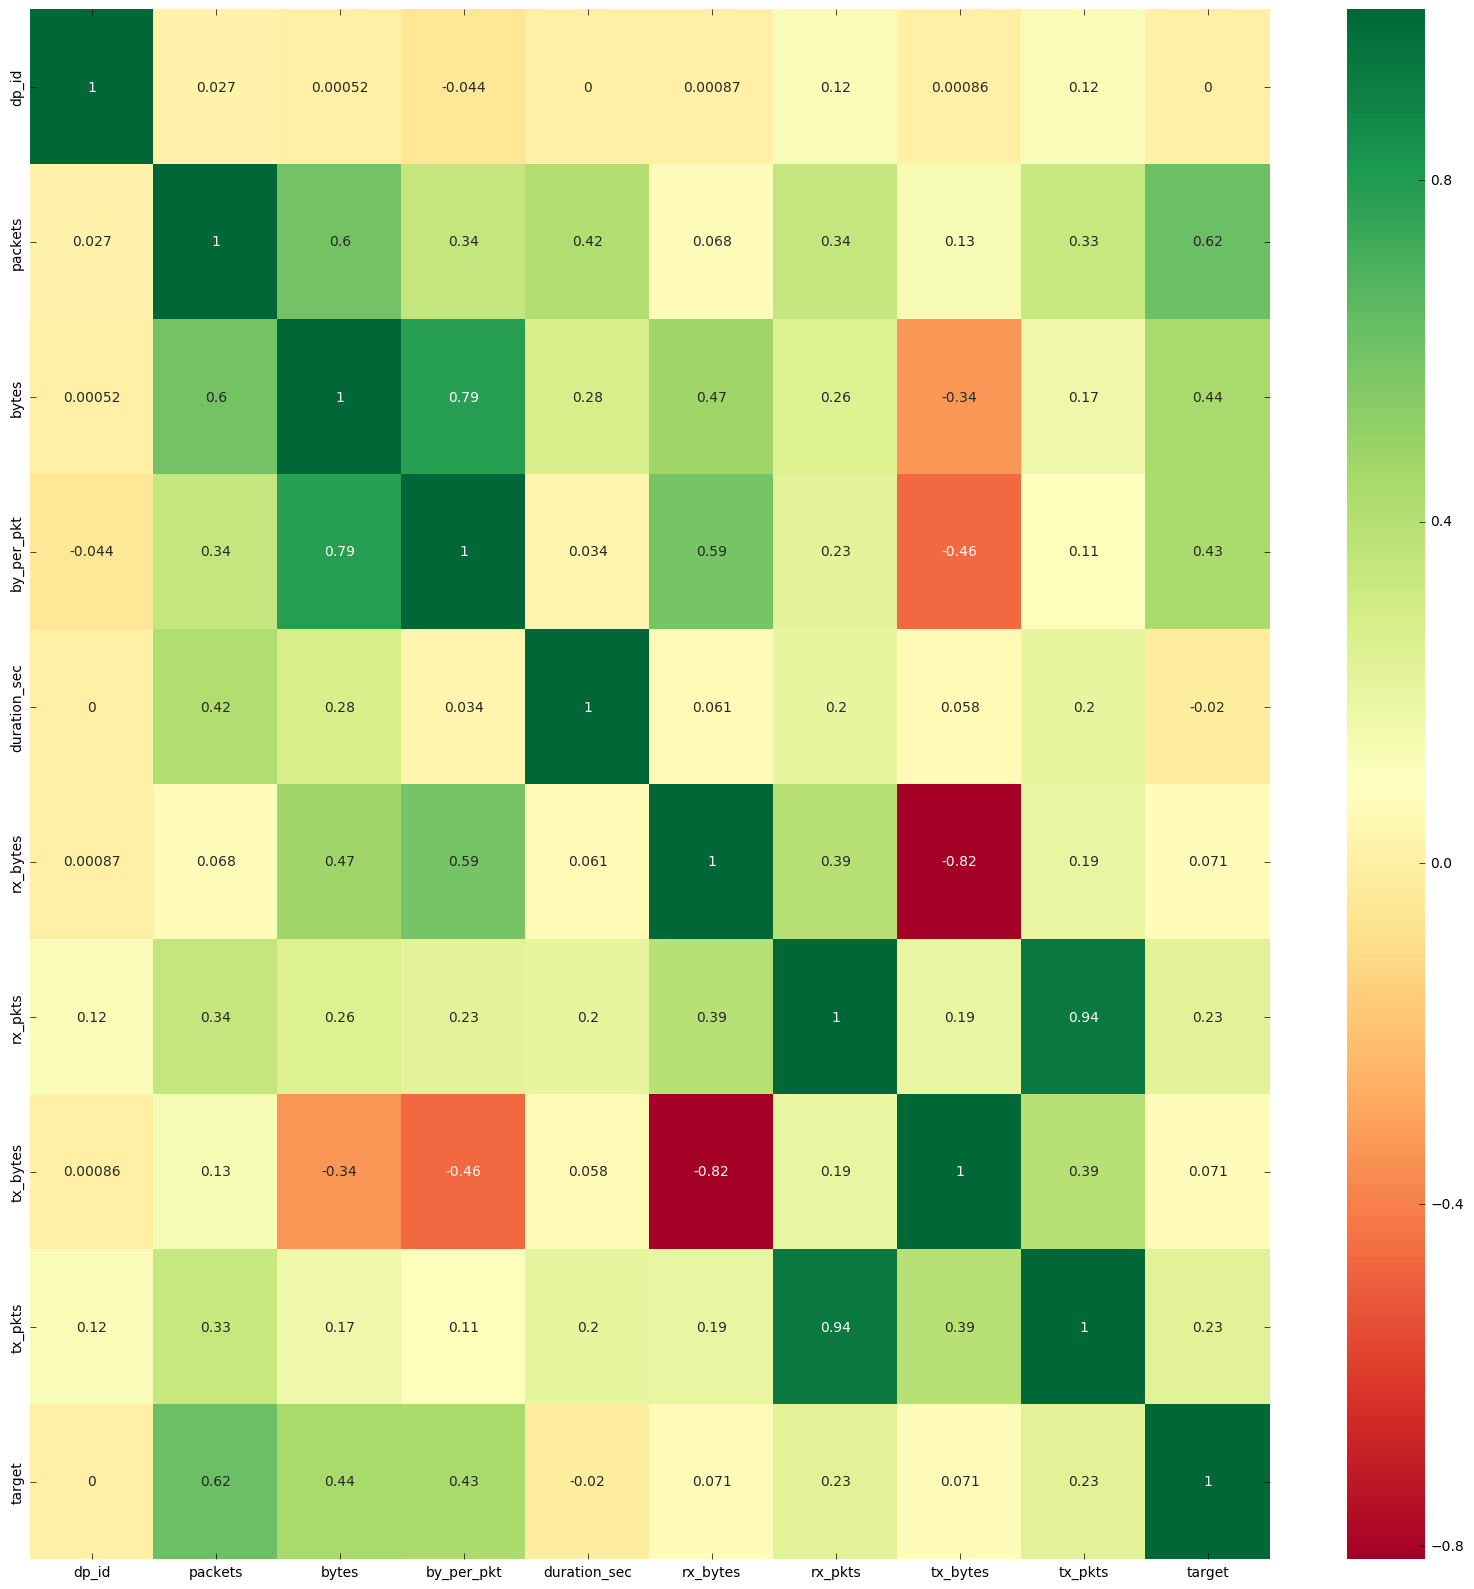

In [190]:
plt.show()
# plt.savefig("heatmap")

In [193]:
features1 = ["dp_id","packets","bytes","by_per_pkt","duration_sec","rx_bytes","rx_pkts","tx_bytes","tx_pkts"]
selector = SelectKBest(score_func=chi2, k=8)
fit = selector.fit(df1[features1],df1["target"])
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(headers)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(8,'Score'))  #print the feature score

          Specs         Score
2         bytes  2.580096e+12
7      tx_bytes  1.343549e+12
5      rx_bytes  1.331437e+12
1       packets  8.013444e+08
8       tx_pkts  3.964553e+08
6       rx_pkts  3.962175e+08
3    by_per_pkt  4.863503e+06
4  duration_sec  3.796773e+03


In [194]:
features = ["by_per_pkt","rx_pkts","tx_pkts"]
# features = ["rx_pkts","tx_pkts","packets"]
y = preprocessing.LabelEncoder().fit_transform(df["target"])
y

array([1, 1, 1, ..., 2, 2, 2])

In [196]:
scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
df1[features] = scaler.fit_transform(df1[features])
x = df1[features]
x[:4]

,by_per_pkt,rx_pkts,tx_pkts
0,0.010219,0.000000,0.009909
1,0.007710,0.009907,0.000000
2,0.007713,0.014277,0.000006
3,0.010220,0.000010,0.014277


In [197]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=None)

In [198]:
kmeans = KMeans(n_clusters=3, random_state=5,n_init=50,precompute_distances=True).fit(X_train)

In [199]:
predict = kmeans.predict(X_test)

In [200]:
kmeans.inertia_

239.28729100604968

In [201]:
kmeans.n_iter_

3

In [244]:
lable_dict = {2:2,1:1,0:0}
count = 0
for i in range(0,len(y_test)):
    if lable_dict[y_test[i]] != predict[i]:
        count = count + 1
accuracy = 1 - count/len(y_test)
print("accuracy:",accuracy)

accuracy: 0.5249003984063745


In [203]:
kmeans.cluster_centers_

array([[0.0320523 , 0.63876215, 0.65626654],
       [0.02082275, 0.12546152, 0.12477941],
       [0.6184325 , 0.69393708, 0.62877855]])

In [204]:
kmeans.labels_

array([0, 0, 2, ..., 0, 0, 0], dtype=int32)

In [243]:
# df[df["target"] == 1]

In [206]:
org["new"] = org["bytes"]/org["packets"]

In [246]:
# org[org["target"] == "hangout"]

In [237]:
x1 = df1[1250:1274]
x1 = x1[features]

In [238]:
pre = kmeans.predict(x1)

In [239]:
pre

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0], dtype=int32)

In [247]:
# from sklearn.externals import joblib
# joblib.dump(kmeans,'kmeans_model_qos.pkl',compress=9)

['kmeans_model_qos.pkl']